No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Sentiment Analysis Complete. Columns now include:  Index(['text', 'Created_At', 'label', 'cleaned_text', 'augmented_text',
       'sentiment'],
      dtype='object')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Fold 1/2
Epoch 1/2, Loss: 0.451574892463053
Epoch 2/2, Loss: 0.21179195822161787
Fold 1 Accuracy: 0.9266821345707656
Training Fold 2/2
Epoch 1/2, Loss: 0.18987514484016335
Epoch 2/2, Loss: 0.09774731561158072
Fold 2 Accuracy: 0.9651972157772621
Final Cross-Validated Accuracy: 0.9459396751740139
Precision: 0.9305555555555556, Recall: 0.9638051044083527, F1-Score: 0.9468885343059038


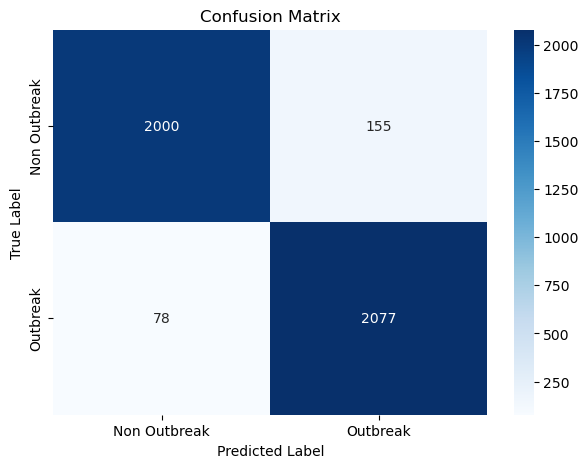

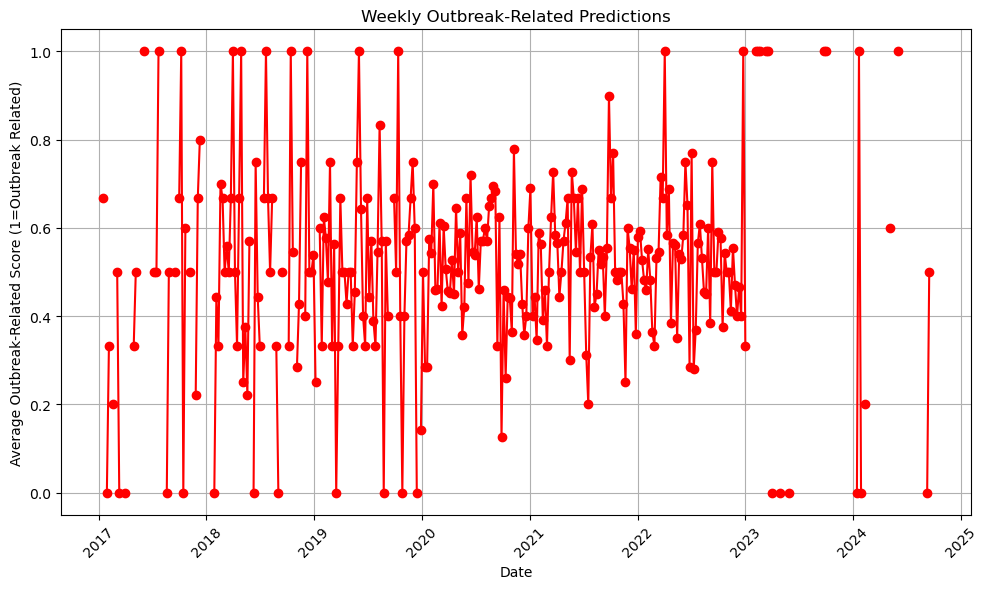

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
import re
import nlpaug.augmenter.word as naw
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Configurable Hyperparameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 32
EPOCHS = 2
SMOTE_ENABLED = True  # Set to True to use SMOTE, False to use SynonymAug
AUGMENTATION_METHOD = 'synonym'  # Options: 'synonym' or 'smote'

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Load the datasets
news_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/news_article.csv')
tweets_data = pd.read_csv('/Users/m1/Downloads/data/VHF/EWS/tweets.csv')

# Step 2: Drop irrelevant columns
columns_to_drop = ['id', 'Tweet_count', 'Retweet_Count', 'User', 'Favorite_Count', 'Comments', 'link', 'publisher']
tweets_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
news_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Step 3: Handle Datetime columns in both datasets
tweets_data['Created_At'] = pd.to_datetime(tweets_data['Created_At'], errors='coerce', format='%a %b %d %H:%M:%S %z %Y').dt.tz_localize(None)
news_data['date published'] = pd.to_datetime(news_data['date published'], errors='coerce', format='%d/%m/%Y %H:%M')
news_data.rename(columns={'date published': 'Created_At'}, inplace=True)

# Step 4: Data Cleaning and Preprocessing
def clean_text(text):
    """Cleans text data by removing URLs and special characters."""
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

# Apply text cleaning
tweets_data['cleaned_text'] = tweets_data['text'].apply(clean_text)
news_data['cleaned_text'] = news_data['text'].apply(clean_text)

# Combine datasets
merged_data = pd.concat([tweets_data, news_data], ignore_index=True)

# Step 5: Data Augmentation (Handling Imbalance)
if AUGMENTATION_METHOD == 'synonym':
    # Using synonym replacement for augmentation
    aug = naw.SynonymAug(aug_src='wordnet')
    majority_class = merged_data[merged_data['label'] == 'Outbreak Related']
    minority_class = merged_data[merged_data['label'] == 'Non Outbreak Related']

    # Upsample minority class
    minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
    minority_upsampled['augmented_text'] = minority_upsampled['cleaned_text'].apply(lambda x: ' '.join(aug.augment(x)))
    merged_data_balanced = pd.concat([majority_class, minority_upsampled]).sample(frac=1, random_state=42)

elif AUGMENTATION_METHOD == 'smote' and SMOTE_ENABLED:
    # Using SMOTE for oversampling
    from sklearn.model_selection import train_test_split
    X = merged_data['cleaned_text']
    y = merged_data['label']

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train.values.reshape(-1, 1), y_train)
    merged_data_balanced = pd.DataFrame(X_resampled, columns=['cleaned_text'])
    merged_data_balanced['label'] = y_resampled

# Step 6: Convert 'label' column to numeric
merged_data_balanced['label'] = merged_data_balanced['label'].map({
    'Non Outbreak Related': 0,
    'Outbreak Related': 1
})

# Step 7: Initialize Sentiment Analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Step 8: Sentiment Analysis on cleaned text
merged_data_balanced['sentiment'] = merged_data_balanced['cleaned_text'].apply(lambda x: sentiment_analyzer(x)[0]['label'])
print("Sentiment Analysis Complete. Columns now include: ", merged_data_balanced.columns)

# Convert sentiment to numeric
merged_data_balanced['sentiment_numeric'] = merged_data_balanced['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0)

# Step 9: Tokenization using BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text_list):
    """Tokenizes text data using BERT tokenizer."""
    return tokenizer(text_list, padding=True, truncation=True, max_length=64, return_tensors='pt')

# Tokenize the text
merged_data_balanced['combined_text'] = merged_data_balanced['cleaned_text'].astype(str)
tokenized_data = tokenize_text(merged_data_balanced['combined_text'].tolist())
input_ids = tokenized_data['input_ids']
attention_masks = tokenized_data['attention_mask']

# Encode labels
labels = torch.tensor(merged_data_balanced['label'].values)

# Step 10: BERT Model Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Cross-validation with StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Mixed Precision Training using GradScaler
scaler = GradScaler(enabled=torch.cuda.is_available())

# Training Loop
accuracy_scores = []
bert_preds = []
all_true_labels = []

for fold, (train_idx, test_idx) in enumerate(skf.split(input_ids, labels)):
    print(f"Training Fold {fold + 1}/{skf.get_n_splits()}")

    train_inputs, test_inputs = input_ids[train_idx], input_ids[test_idx]
    train_masks, test_masks = attention_masks[train_idx], attention_masks[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    # Create DataLoaders
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=BATCH_SIZE)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=BATCH_SIZE)

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

    # Train the model
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_attention_mask, b_labels = batch
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            optimizer.zero_grad()

            with autocast(enabled=torch.cuda.is_available()):
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_dataloader)}")

    # Evaluate the model
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_attention_mask = batch[0].to(device), batch[1].to(device)
            outputs = model(b_input_ids, attention_mask=b_attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).flatten()

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch[2].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    accuracy_scores.append(accuracy)
    bert_preds.extend(predictions)  # Store BERT predictions
    all_true_labels.extend(true_labels)  # Store true labels

    print(f"Fold {fold + 1} Accuracy: {accuracy}")

# Final Evaluation Metrics
final_accuracy = accuracy_score(all_true_labels, bert_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_true_labels, bert_preds, average='binary')
print(f"Final Cross-Validated Accuracy: {final_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_true_labels, bert_preds)

# Plot Confusion Matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Outbreak', 'Outbreak'], yticklabels=['Non Outbreak', 'Outbreak'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save BERT predictions for meta-learner
pd.DataFrame(bert_preds, columns=['bert_predictions']).to_csv('bert_predictions.csv', index=False)
pd.DataFrame(all_true_labels, columns=['true_labels']).to_csv('true_labels.csv', index=False)

# Step 11: Temporal Outbreak Predictions (Integrated)
merged_data_balanced['outbreak_prediction'] = bert_preds

# Resample outbreak predictions weekly
weekly_outbreak_predictions = merged_data_balanced.set_index('Created_At').resample('W').outbreak_prediction.mean()

# Plot the outbreak-related predictions over time
plt.figure(figsize=(10, 6))
plt.plot(weekly_outbreak_predictions, marker='o', linestyle='-', color='r')
plt.title('Weekly Outbreak-Related Predictions')
plt.ylabel('Average Outbreak-Related Score (1=Outbreak Related)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Class distribution before SMOTE:
No Outcome Yet    16864
Recovered          2612
Deceased            585
Name: outcome_case, dtype: int64
Model accuracy: 0.7732057416267942
Confusion Matrix:
 [[366 142]
 [ 95 442]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.72      0.76       508
         1.0       0.76      0.82      0.79       537

    accuracy                           0.77      1045
   macro avg       0.78      0.77      0.77      1045
weighted avg       0.77      0.77      0.77      1045

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters found:  {'classifier__learning_rate': 0.2, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
Best cross-validated accuracy:  0.7544867193108399
Tuned Model accuracy: 0.7655502392344498
Tuned Confusion Matrix:
 [[356 152]
 [ 93 444]]
Tuned Classification Report:
               precision    recall  f1-score   support

         0.0       0.79     

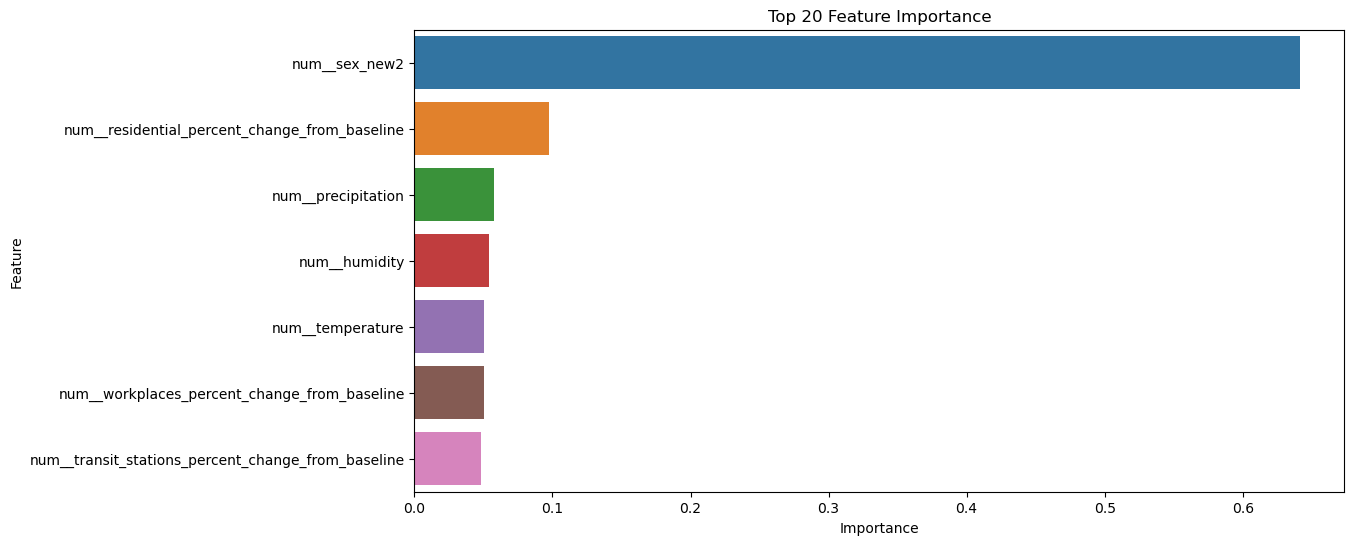

Predictions saved to xgboost_predictions.csv


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore")

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Step 1: Load datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Step 2: Select relevant columns (Expanded)
lassa_fever_data_relevant = lassa_fever_data[[
    'DID', 'age_grouped', 'sex_new2', 'Pregnancy', 'occupation_updated_new', 'educ_updatedcat', 
    'Stateofresidence_updated', 'InitialSampleFinalLaboratoryResultPathogentest', 
    'LatestSampleFinalLaboratoryResultPathogentest', 'outcome_case', 'Symptomatic', 
    'fever_new', 'diarrhea_new', 'vomiting_new', 'headache_new', 'acute_hearing_loss', 
    'bleeding_gums', 'nose_bleeding', 'blood_urine', 'direct_contact_probable_case',
    'date_symptom_onset2', 'date_of_outcome2', 'date_visit_or_admision2', 
    'initial_sample_date2', 'DateofreportMdyyyy',
    'LGA_of_residence', 'geopolitical_zone'
]].copy()

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'date', 'workplaces_percent_change_from_baseline', 'sub_region_2',
                                        'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline']].copy()

# Filter to keep only rows where sub_region_2 is null
mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]

# Step 3: Rename columns for consistency
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

# Step 4: Convert the date columns to datetime format
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Step 5: Handle missing or invalid values
lassa_fever_data_relevant.dropna(subset=['state'], inplace=True)
lassa_fever_data_relevant.fillna(method='ffill', inplace=True)

# Step 6: Merge climatic data
merged_data = lassa_fever_data_relevant.merge(climatic_data_relevant, on=['state', 'date'], how='left')

# Step 7: Merge mobility data
merged_data = merged_data.merge(mobility_data_relevant, left_on=['state', 'date'], right_on=['state', 'date'], how='left')

# Step 8: Drop unnecessary columns and handle missing values
merged_data.drop(columns=['sub_region_2'], inplace=True)

# Fill missing values
merged_data['Pregnancy'].fillna('Unknown', inplace=True)
merged_data['direct_contact_probable_case'].fillna('UNKNOWN', inplace=True)
merged_data['date_of_outcome2'].fillna('UNKNOWN', inplace=True)
merged_data.dropna(subset=['initial_sample_date2'], inplace=True)

# Fill missing values with mean for numeric columns
for column in ['workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline', 
               'transit_stations_percent_change_from_baseline', 'temperature', 'humidity', 'precipitation']:
    merged_data[column].fillna(merged_data[column].mean(), inplace=True)

# Step 9: Prepare for model training
target = merged_data['outcome_case']
features = merged_data.drop(columns=['outcome_case', 'date', 'date_of_outcome2', 
                                      'date_visit_or_admision2', 'initial_sample_date2', 
                                      'DateofreportMdyyyy'])

# Step 10: Handle class imbalance
print("Class distribution before SMOTE:")
print(target.value_counts())

# Filter the target variable to relevant classes
target = target[target.isin(['Recovered', 'Deceased'])]
features = features.loc[target.index]

# Map target labels to numeric values
target = target.map({'Recovered': 1, 'Deceased': 0})

# Convert categorical features to numerical
for col in features.select_dtypes(include=['category', 'object']).columns:
    features[col] = features[col].astype('category').cat.codes

# Step 11: Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(features, target)

# Ensure that X_balanced is a DataFrame after SMOTE
X_balanced = pd.DataFrame(X_balanced, columns=features.columns)

# Step 12: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Step 13: Set up the XGBoost model with a pipeline
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42, eval_metric='logloss')

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()),  # Scale numerical features
            ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object', 'category']).columns.tolist())  # One-hot encode categorical features
        ]
    )),
    ('classifier', xgb_model)
])

# Step 14: Fit the model using the pipeline
pipeline.fit(X_train, y_train)

# Step 15: Make predictions
xgboost_preds = pipeline.predict(X_test)  # Store predictions in xgboost_preds

# Step 16: Evaluate the model
print("Model accuracy:", accuracy_score(y_test, xgboost_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgboost_preds))
print("Classification Report:\n", classification_report(y_test, xgboost_preds))

# Step 17: Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated accuracy: ", grid_search.best_score_)

# Step 18: Evaluate the tuned model and store predictions
best_pipeline = grid_search.best_estimator_
xgboost_preds = best_pipeline.predict(X_test)  # Store predictions in xgboost_preds

# Evaluate tuned model
print("Tuned Model accuracy:", accuracy_score(y_test, xgboost_preds))
print("Tuned Confusion Matrix:\n", confusion_matrix(y_test, xgboost_preds))
print("Tuned Classification Report:\n", classification_report(y_test, xgboost_preds))

# Step 19: Feature Importance Visualization
# Retrieve the best model from the pipeline
xgb_model_best = pipeline.named_steps['classifier']

# Use the fitted preprocessor to transform X_balanced and get the feature names
X_transformed = pipeline.named_steps['preprocessor'].transform(X_balanced)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get the feature importance from the best model
importance = xgb_model_best.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance')
plt.show()


# Save the predictions to a CSV file
output_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': xgboost_preds
})

# Save to CSV
output_df.to_csv('xgboost_predictions.csv', index=False)
print("Predictions saved to xgboost_predictions.csv")

Epoch [10/100], Train Loss: 72.8214, Test Loss (Reg/Cls): 105.1798/0.6845
Epoch [20/100], Train Loss: 52.6833, Test Loss (Reg/Cls): 75.1167/0.4590
Epoch [30/100], Train Loss: 39.0026, Test Loss (Reg/Cls): 46.8891/0.2068
Epoch [40/100], Train Loss: 38.1869, Test Loss (Reg/Cls): 43.5655/0.1955
Epoch [50/100], Train Loss: 38.2511, Test Loss (Reg/Cls): 43.7569/0.2075
Epoch [60/100], Train Loss: 38.1152, Test Loss (Reg/Cls): 44.0017/0.2125
Epoch [70/100], Train Loss: 37.9268, Test Loss (Reg/Cls): 44.0187/0.2113
Epoch [80/100], Train Loss: 37.7269, Test Loss (Reg/Cls): 44.1117/0.2084
Epoch [90/100], Train Loss: 37.3642, Test Loss (Reg/Cls): 43.8972/0.2039
Epoch [100/100], Train Loss: 36.7317, Test Loss (Reg/Cls): 43.9480/0.1987
MSE (Regression): 43.9480, MAE (Regression): 5.3516
Accuracy (Classification): 0.9518, Precision: 0.4760, Recall: 0.4999, F1-Score: 0.4877, ROC AUC: 0.5575


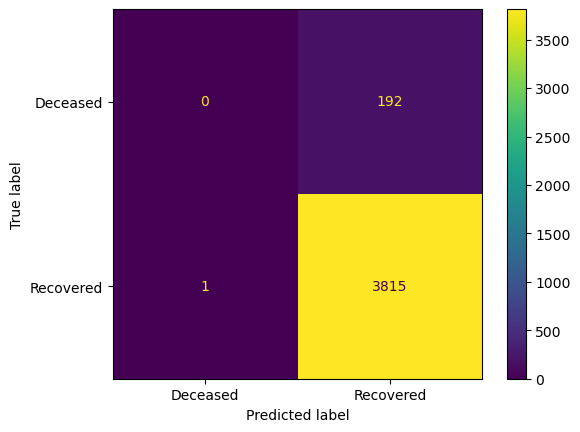

LSTM Predictions saved to lstm_predictions.csv


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Load and preprocess your datasets
try:
    lassa_fever_data = pd.read_spss('/Users/m1/Downloads/data/VHF/Lassa Fever_Dataset_NCDC.sav')
    climatic_data = pd.read_csv('/Users/m1/Downloads/data/VHF/main_nasa_power_climatic_data_VHF 2.csv')
    mobility_data = pd.read_csv('/Users/m1/Downloads/data/VHF/2020-2022_NG_Region_Mobility_Report.csv')
except Exception as e:
    print(f"Error loading datasets: {e}")

# Step 2: Select relevant columns and preprocess
lassa_fever_data_relevant = lassa_fever_data[['date_symptom_onset2', 'outcome_case', 'Stateofresidence_updated',
                                             'age_grouped', 'sex_new2', 'InitialSampleFinalLaboratoryResultPathogentest',
                                             'Symptomatic', 'fever_new', 'date_of_outcome2', 'date_visit_or_admision2', 
                                             'LGA_of_residence', 'geopolitical_zone']].copy()

# Create 'case_count' by aggregating data if needed
case_counts = lassa_fever_data_relevant.groupby(['date_symptom_onset2', 'Stateofresidence_updated']).size().reset_index(name='case_count')
lassa_fever_data_relevant = lassa_fever_data_relevant.merge(case_counts, on=['date_symptom_onset2', 'Stateofresidence_updated'], how='left')

climatic_data_relevant = climatic_data[['state', 'date', 'temperature', 'humidity', 'precipitation', 'dew_point', 'surface_pressure']].copy()
mobility_data_relevant = mobility_data[['sub_region_1', 'sub_region_2', 'date', 'workplaces_percent_change_from_baseline',
                                       'residential_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline',
                                       'retail_and_recreation_percent_change_from_baseline']].copy()

# Filter to keep only rows where sub_region_2 is null
mobility_data_relevant = mobility_data_relevant[mobility_data_relevant['sub_region_2'].isnull()]
    
# Rename columns for consistency
lassa_fever_data_relevant.rename(columns={'Stateofresidence_updated': 'state', 'date_symptom_onset2': 'date'}, inplace=True)
mobility_data_relevant.rename(columns={'sub_region_1': 'state'}, inplace=True)

# Convert date columns to datetime
lassa_fever_data_relevant['date'] = pd.to_datetime(lassa_fever_data_relevant['date'], errors='coerce')
climatic_data_relevant['date'] = pd.to_datetime(climatic_data_relevant['date'], format='%Y%m%d', errors='coerce')
mobility_data_relevant['date'] = pd.to_datetime(mobility_data_relevant['date'], format='%d/%m/%Y', errors='coerce')

# Merge datasets
merged_data = lassa_fever_data_relevant.merge(climatic_data_relevant, on=['state', 'date'], how='left')
merged_data = merged_data.merge(mobility_data_relevant, on=['state', 'date'], how='left')

# Fill missing values
merged_data.fillna(method='ffill', inplace=True)

# Drop unnecessary columns and handle missing values
merged_data.drop(columns=['sub_region_2'], inplace=True)
merged_data = merged_data.dropna(subset=['date_of_outcome2', 'transit_stations_percent_change_from_baseline', 'retail_and_recreation_percent_change_from_baseline'])

# Replace 'No Outcome Yet' with 'Recovered' in the 'outcome_case' column
merged_data['outcome_case'] = merged_data['outcome_case'].replace('No Outcome Yet', 'Recovered')

# Encode 'outcome_case' for classification (e.g., 'Recovered' = 1, 'Deceased' = 0)
label_encoder = LabelEncoder()
merged_data['outcome_case_encoded'] = label_encoder.fit_transform(merged_data['outcome_case'])
merged_data['state_encoded'] = label_encoder.fit_transform(merged_data['state']) 
merged_data['InitialSampleFinalLaboratoryResultPathogentest_encoded'] = label_encoder.fit_transform(merged_data['InitialSampleFinalLaboratoryResultPathogentest'])
merged_data['sex_new2_encoded'] = label_encoder.fit_transform(merged_data['sex_new2'])
merged_data['Symptomatic_encoded'] = label_encoder.fit_transform(merged_data['Symptomatic'])
merged_data['fever_new_encoded'] = label_encoder.fit_transform(merged_data['fever_new'])
merged_data['geopolitical_zone_encoded'] = label_encoder.fit_transform(merged_data['geopolitical_zone'])

# Step 3: Prepare features and target
features = merged_data.drop(columns=['case_count', 'outcome_case_encoded', 'outcome_case', 'state', 'date', 'age_grouped', 'InitialSampleFinalLaboratoryResultPathogentest',
                                    'sex_new2', 'Symptomatic', 'fever_new', 'date_of_outcome2', 'date_visit_or_admision2', 'LGA_of_residence', 'geopolitical_zone'])
target_case_count = merged_data['case_count']  # For regression
target_outcome = merged_data['outcome_case_encoded']  # For classification

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply SMOTE to balance the target variable
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features_scaled, target_outcome)

# Adjust target_case_count_resampled to match the resampled data size
target_case_count_resampled = target_case_count[:len(X_resampled)]

# Create time series data for LSTM (7-day sequences)
def create_dataset(data, target_reg, target_class, time_step=7):
    X, y_reg, y_class = [], [], []
    max_len = min(len(data), len(target_reg), len(target_class)) - time_step - 1
    for i in range(max_len):
        X.append(data[i:(i + time_step), :])
        y_reg.append(target_reg[i + time_step])  # Case count for regression
        y_class.append(target_class[i + time_step])  # Binary outcome
    return np.array(X), np.array(y_reg), np.array(y_class)

# Now, pass the resampled data to the create_dataset function
X, y_reg, y_class = create_dataset(X_resampled, target_case_count_resampled.values, y_resampled, time_step=7)

# Train-test split
X_train, X_test, y_train_reg, y_test_reg, y_train_class, y_test_class = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42, shuffle=False
)

# Define LSTM Model for Multi-task Learning (Regression + Classification)
class LSTMRegressionClassification(nn.Module):
    def __init__(self, input_size):
        super(LSTMRegressionClassification, self).__init__()
        self.lstm = nn.LSTM(input_size, 100, num_layers=2, batch_first=True, dropout=0.3)
        self.fc_reg = nn.Linear(100, 1)  # Output layer for regression
        self.fc_class = nn.Linear(100, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid for binary output
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out_reg = self.fc_reg(out[:, -1, :])  # Regression output
        out_class = self.sigmoid(self.fc_class(out[:, -1, :]))  # Classification output
        return out_reg, out_class

# Instantiate model, define loss and optimizer
input_size = X_train.shape[2]  # Number of features
model = LSTMRegressionClassification(input_size)
criterion_reg = nn.MSELoss()
criterion_class = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_reg_tensor = torch.Tensor(y_train_reg).unsqueeze(1)  # Reshape for regression
y_train_class_tensor = torch.Tensor(y_train_class).unsqueeze(1)  # Reshape for classification
X_test_tensor = torch.Tensor(X_test)
y_test_reg_tensor = torch.Tensor(y_test_reg).unsqueeze(1)
y_test_class_tensor = torch.Tensor(y_test_class).unsqueeze(1)

# Train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    outputs_reg, outputs_class = model(X_train_tensor)
    
    # Calculate losses for both regression and classification
    loss_reg = criterion_reg(outputs_reg, y_train_reg_tensor)
    loss_class = criterion_class(outputs_class, y_train_class_tensor)
    
    # Combine losses (weighted sum)
    loss = (0.7 * loss_reg) + (0.3 * loss_class)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_outputs_reg, test_outputs_class = model(X_test_tensor)
            test_loss_reg = criterion_reg(test_outputs_reg, y_test_reg_tensor)
            test_loss_class = criterion_class(test_outputs_class, y_test_class_tensor)
        print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Test Loss (Reg/Cls): {test_loss_reg.item():.4f}/{test_loss_class.item():.4f}')
        
# Evaluate regression and classification performance separately
with torch.no_grad():
    lstm_preds_reg, lstm_preds_class_prob = model(X_test_tensor)  # Predictions for regression and classification
    lstm_preds_class = (lstm_preds_class_prob > 0.5).float()  # Binary classification

# Performance Metrics for Regression
mse = mean_squared_error(y_test_reg, lstm_preds_reg)
mae = mean_absolute_error(y_test_reg, lstm_preds_reg)
print(f'MSE (Regression): {mse:.4f}, MAE (Regression): {mae:.4f}')

# Performance Metrics for Classification
accuracy = accuracy_score(y_test_class, lstm_preds_class.numpy())
precision = precision_score(y_test_class, lstm_preds_class.numpy(), average='macro', zero_division=0)
recall = recall_score(y_test_class, lstm_preds_class.numpy(), average='macro')
f1 = f1_score(y_test_class, lstm_preds_class.numpy(), average='macro')
roc_auc = roc_auc_score(y_test_class, lstm_preds_class_prob.numpy(), multi_class='ovr')

print(f'Accuracy (Classification): {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test_class, lstm_preds_class)
ConfusionMatrixDisplay(cm, display_labels=['Deceased', 'Recovered']).plot()
plt.show()

# Save the predictions (classification) to a CSV file
output_df = pd.DataFrame({
    'True_Label': y_test_class,
    'Predicted_Label': lstm_preds_class.numpy().flatten()
})

# Save to CSV
output_df.to_csv('lstm_predictions.csv', index=False)
print("LSTM Predictions saved to lstm_predictions.csv")


In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# These are the predictions from your individual models (BERT, XGBoost, and LSTM Classification)
bert_preds = bert_preds       # BERT predictions on outbreak likelihood (0 or 1)
xgb_preds = xgb_preds       # XGBoost predictions on outbreak likelihood (0 or 1)
lstm_preds_class = lstm_preds_class # LSTM classification predictions (0 or 1)
lstm_preds_reg = lstm_preds_reg   # LSTM regression predictions (case counts)

# Ground truth labels (replace with your actual target data)
y_true = y_test  # Example ground truth, replace with real labels

# Step 1: Combine the predictions into a single DataFrame
meta_features = pd.DataFrame({
    'bert_pred': bert_preds,          # BERT predictions
    'xgb_pred': xgb_preds,            # XGBoost predictions
    'lstm_pred_class': lstm_preds_class, # LSTM classification predictions
    'lstm_pred_reg': lstm_preds_reg   # LSTM regression predictions
})

# Step 2: Split the combined dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(meta_features, y_true, test_size=0.2, random_state=42)

# Step 3: Initialize the meta-learner (Random Forest)
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 4: Train the meta-learner on the combined predictions
meta_model.fit(X_train, y_train)

# Step 5: Make predictions using the meta-learner
meta_preds = meta_model.predict(X_test)

# Step 6: Evaluate the meta-learner performance
print("Meta-Learner Accuracy:", accuracy_score(y_test, meta_preds))
print("Classification Report:\n", classification_report(y_test, meta_preds))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, meta_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Outbreak', 'Outbreak'], yticklabels=['Non Outbreak', 'Outbreak'])
plt.title('Meta-Learner Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 7: Cross-Validation to check generalizability
cv_scores = cross_val_score(meta_model, meta_features, y_true, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

# Step 8: Feature Importance (optional) - to see which model contributes the most
feature_importance = meta_model.feature_importances_
importance_df = pd.DataFrame({
    'Model': ['BERT', 'XGBoost', 'LSTM Class', 'LSTM Reg'],  # Now we have 4 features
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Model', data=importance_df)
plt.title('Feature Importance of Models in Meta-Learner')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [100, 20]

In [10]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Define the Q-network (Deep Neural Network)
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Hyperparameters
state_size = 3  # Number of features from ensemble model (bert_preds, xgb_preds, lstm_preds)
action_size = 3  # Number of possible interventions/actions (e.g., quarantine, allocate resources, close public spaces)
gamma = 0.95  # Discount factor for future rewards
learning_rate = 0.001
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
memory_size = 1000
num_episodes = 1000

# Initialize Q-network, optimizer, and loss function
dqn = DQNetwork(state_size, action_size)
optimizer = optim.Adam(dqn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Experience replay memory
memory = deque(maxlen=memory_size)

# Function to choose action (exploration vs exploitation)
def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Random action (exploration)
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = dqn(state)
        return np.argmax(q_values.detach().numpy())  # Exploitation (choose the best action)

# Function to store experiences in memory
def store_memory(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Function to replay experiences from memory and update the network
def replay(batch_size):
    if len(memory) < batch_size:
        return
    
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        q_values = dqn(state)
        target = q_values.clone()
        
        if done:
            target[0][action] = reward
        else:
            next_q_values = dqn(next_state)
            target[0][action] = reward + gamma * torch.max(next_q_values)
        
        loss = criterion(q_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Function to update the exploration rate (epsilon)
def update_epsilon(epsilon):
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay
    return epsilon

# Simulate environment and reward
def get_reward(action):
    # Example: Reward is +1 if the action was beneficial (e.g., reduced outbreak), -1 otherwise
    # Replace with real logic based on your problem domain
    if action == 0:  # Example: Quarantine
        return np.random.choice([1, -1], p=[0.7, 0.3])  # 70% chance quarantine is beneficial
    elif action == 1:  # Resource allocation
        return np.random.choice([1, -1], p=[0.6, 0.4])
    elif action == 2:  # Closing public spaces
        return np.random.choice([1, -1], p=[0.5, 0.5])

# Training Deep Q-Learning
for episode in range(num_episodes):
    # Initial state (ensemble predictions as state input)
    state = np.array([bert_preds[episode % len(bert_preds)], xgb_preds[episode % len(xgb_preds)], lstm_preds_class[episode % len(lstm_preds_class)]])
    total_reward = 0
    done = False

    while not done:
        # Choose action based on current state
        action = choose_action(state, epsilon)
        
        # Take action and get reward and next state
        reward = get_reward(action)
        next_state = np.array([bert_preds[(episode + 1) % len(bert_preds)], xgb_preds[(episode + 1) % len(xgb_preds)], lstm_preds_class[(episode + 1) % len(lstm_preds_class)]])
        
        # Check if episode is done (for simplicity, say episode ends after one step)
        done = True
        
        # Store experience in memory
        store_memory(state, action, reward, next_state, done)
        
        # Replay and train the model
        replay(batch_size)
        
        # Update state and total reward
        state = next_state
        total_reward += reward
    
    # Update epsilon for exploration/exploitation balance
    epsilon = update_epsilon(epsilon)
    
    print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

print("Training complete!")


Episode 1/1000, Total Reward: -1, Epsilon: 0.99
Episode 2/1000, Total Reward: 1, Epsilon: 0.99
Episode 3/1000, Total Reward: -1, Epsilon: 0.99
Episode 4/1000, Total Reward: 1, Epsilon: 0.98
Episode 5/1000, Total Reward: -1, Epsilon: 0.98
Episode 6/1000, Total Reward: 1, Epsilon: 0.97
Episode 7/1000, Total Reward: -1, Epsilon: 0.97
Episode 8/1000, Total Reward: -1, Epsilon: 0.96
Episode 9/1000, Total Reward: -1, Epsilon: 0.96
Episode 10/1000, Total Reward: -1, Epsilon: 0.95
Episode 11/1000, Total Reward: -1, Epsilon: 0.95
Episode 12/1000, Total Reward: 1, Epsilon: 0.94
Episode 13/1000, Total Reward: 1, Epsilon: 0.94
Episode 14/1000, Total Reward: -1, Epsilon: 0.93
Episode 15/1000, Total Reward: -1, Epsilon: 0.93
Episode 16/1000, Total Reward: 1, Epsilon: 0.92
Episode 17/1000, Total Reward: 1, Epsilon: 0.92
Episode 18/1000, Total Reward: -1, Epsilon: 0.91
Episode 19/1000, Total Reward: 1, Epsilon: 0.91
Episode 20/1000, Total Reward: -1, Epsilon: 0.90
Episode 21/1000, Total Reward: 1, Eps

Episode 180/1000, Total Reward: 1, Epsilon: 0.41
Episode 181/1000, Total Reward: 1, Epsilon: 0.40
Episode 182/1000, Total Reward: 1, Epsilon: 0.40
Episode 183/1000, Total Reward: 1, Epsilon: 0.40
Episode 184/1000, Total Reward: -1, Epsilon: 0.40
Episode 185/1000, Total Reward: 1, Epsilon: 0.40
Episode 186/1000, Total Reward: -1, Epsilon: 0.39
Episode 187/1000, Total Reward: -1, Epsilon: 0.39
Episode 188/1000, Total Reward: 1, Epsilon: 0.39
Episode 189/1000, Total Reward: 1, Epsilon: 0.39
Episode 190/1000, Total Reward: 1, Epsilon: 0.39
Episode 191/1000, Total Reward: 1, Epsilon: 0.38
Episode 192/1000, Total Reward: 1, Epsilon: 0.38
Episode 193/1000, Total Reward: 1, Epsilon: 0.38
Episode 194/1000, Total Reward: 1, Epsilon: 0.38
Episode 195/1000, Total Reward: 1, Epsilon: 0.38
Episode 196/1000, Total Reward: 1, Epsilon: 0.37
Episode 197/1000, Total Reward: 1, Epsilon: 0.37
Episode 198/1000, Total Reward: -1, Epsilon: 0.37
Episode 199/1000, Total Reward: -1, Epsilon: 0.37
Episode 200/100

Episode 368/1000, Total Reward: 1, Epsilon: 0.16
Episode 369/1000, Total Reward: 1, Epsilon: 0.16
Episode 370/1000, Total Reward: 1, Epsilon: 0.16
Episode 371/1000, Total Reward: 1, Epsilon: 0.16
Episode 372/1000, Total Reward: 1, Epsilon: 0.15
Episode 373/1000, Total Reward: 1, Epsilon: 0.15
Episode 374/1000, Total Reward: 1, Epsilon: 0.15
Episode 375/1000, Total Reward: -1, Epsilon: 0.15
Episode 376/1000, Total Reward: 1, Epsilon: 0.15
Episode 377/1000, Total Reward: 1, Epsilon: 0.15
Episode 378/1000, Total Reward: 1, Epsilon: 0.15
Episode 379/1000, Total Reward: -1, Epsilon: 0.15
Episode 380/1000, Total Reward: -1, Epsilon: 0.15
Episode 381/1000, Total Reward: -1, Epsilon: 0.15
Episode 382/1000, Total Reward: 1, Epsilon: 0.15
Episode 383/1000, Total Reward: 1, Epsilon: 0.15
Episode 384/1000, Total Reward: -1, Epsilon: 0.15
Episode 385/1000, Total Reward: -1, Epsilon: 0.15
Episode 386/1000, Total Reward: -1, Epsilon: 0.14
Episode 387/1000, Total Reward: 1, Epsilon: 0.14
Episode 388/1

Episode 540/1000, Total Reward: 1, Epsilon: 0.07
Episode 541/1000, Total Reward: 1, Epsilon: 0.07
Episode 542/1000, Total Reward: -1, Epsilon: 0.07
Episode 543/1000, Total Reward: 1, Epsilon: 0.07
Episode 544/1000, Total Reward: 1, Epsilon: 0.07
Episode 545/1000, Total Reward: 1, Epsilon: 0.07
Episode 546/1000, Total Reward: 1, Epsilon: 0.06
Episode 547/1000, Total Reward: 1, Epsilon: 0.06
Episode 548/1000, Total Reward: 1, Epsilon: 0.06
Episode 549/1000, Total Reward: 1, Epsilon: 0.06
Episode 550/1000, Total Reward: 1, Epsilon: 0.06
Episode 551/1000, Total Reward: -1, Epsilon: 0.06
Episode 552/1000, Total Reward: -1, Epsilon: 0.06
Episode 553/1000, Total Reward: 1, Epsilon: 0.06
Episode 554/1000, Total Reward: 1, Epsilon: 0.06
Episode 555/1000, Total Reward: -1, Epsilon: 0.06
Episode 556/1000, Total Reward: 1, Epsilon: 0.06
Episode 557/1000, Total Reward: 1, Epsilon: 0.06
Episode 558/1000, Total Reward: -1, Epsilon: 0.06
Episode 559/1000, Total Reward: 1, Epsilon: 0.06
Episode 560/100

Episode 710/1000, Total Reward: 1, Epsilon: 0.03
Episode 711/1000, Total Reward: 1, Epsilon: 0.03
Episode 712/1000, Total Reward: -1, Epsilon: 0.03
Episode 713/1000, Total Reward: -1, Epsilon: 0.03
Episode 714/1000, Total Reward: 1, Epsilon: 0.03
Episode 715/1000, Total Reward: 1, Epsilon: 0.03
Episode 716/1000, Total Reward: 1, Epsilon: 0.03
Episode 717/1000, Total Reward: 1, Epsilon: 0.03
Episode 718/1000, Total Reward: -1, Epsilon: 0.03
Episode 719/1000, Total Reward: -1, Epsilon: 0.03
Episode 720/1000, Total Reward: 1, Epsilon: 0.03
Episode 721/1000, Total Reward: -1, Epsilon: 0.03
Episode 722/1000, Total Reward: 1, Epsilon: 0.03
Episode 723/1000, Total Reward: 1, Epsilon: 0.03
Episode 724/1000, Total Reward: -1, Epsilon: 0.03
Episode 725/1000, Total Reward: 1, Epsilon: 0.03
Episode 726/1000, Total Reward: 1, Epsilon: 0.03
Episode 727/1000, Total Reward: 1, Epsilon: 0.03
Episode 728/1000, Total Reward: -1, Epsilon: 0.03
Episode 729/1000, Total Reward: -1, Epsilon: 0.03
Episode 730/

Episode 887/1000, Total Reward: 1, Epsilon: 0.01
Episode 888/1000, Total Reward: 1, Epsilon: 0.01
Episode 889/1000, Total Reward: -1, Epsilon: 0.01
Episode 890/1000, Total Reward: -1, Epsilon: 0.01
Episode 891/1000, Total Reward: -1, Epsilon: 0.01
Episode 892/1000, Total Reward: 1, Epsilon: 0.01
Episode 893/1000, Total Reward: -1, Epsilon: 0.01
Episode 894/1000, Total Reward: 1, Epsilon: 0.01
Episode 895/1000, Total Reward: -1, Epsilon: 0.01
Episode 896/1000, Total Reward: -1, Epsilon: 0.01
Episode 897/1000, Total Reward: 1, Epsilon: 0.01
Episode 898/1000, Total Reward: 1, Epsilon: 0.01
Episode 899/1000, Total Reward: 1, Epsilon: 0.01
Episode 900/1000, Total Reward: 1, Epsilon: 0.01
Episode 901/1000, Total Reward: 1, Epsilon: 0.01
Episode 902/1000, Total Reward: -1, Epsilon: 0.01
Episode 903/1000, Total Reward: -1, Epsilon: 0.01
Episode 904/1000, Total Reward: 1, Epsilon: 0.01
Episode 905/1000, Total Reward: 1, Epsilon: 0.01
Episode 906/1000, Total Reward: -1, Epsilon: 0.01
Episode 907